In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import os
import sys
import math
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import sklearn
from sklearn.model_selection import GridSearchCV 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import missingno as msgo

from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

from sklearn.metrics import (classification_report, plot_confusion_matrix, plot_precision_recall_curve, 
                             plot_roc_curve, precision_score, recall_score, f1_score)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)


In [50]:
from src.eda_utils import insert_note
from src.modeling_utils import plot_train_test_metrics
from src.preprocess import preprocess

In [51]:
raw = pd.read_csv('data/dados.csv', sep=';')
raw.head()                  

/home/jrcunha/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Dia semana agendamento,Ano agendamento,Mes agendamento,Hora agendamento,Dia mes agendamento,Dia semana atendimento,Ano atendimento,Mes atendimento,Hora atendimento,Dia mes atendimento,Secao,Medico preferencial,Renda Provavel,MicroArea,Diretoria,Cod convenio,Codigo exame,Idade,Tempo medio de agendamento,Unidade,Bairro,Feminino,No Show,Unnamed: 23,Legenda
0,6,2019,8,8,18,3,2019,8,15,15,110,0,1028823,377,7,115,465530,39,2,VILLA LOBOS,4218,1,0,NaN,Show = 0
1,2,2019,11,7,6,0,2019,11,13,4,110,0,1028823,377,7,115,465530,39,1,VILLA LOBOS,4218,1,1,NaN,No Show = 1
2,5,2019,8,8,31,3,2019,8,15,15,36,0,1028823,377,7,115,465530,39,15,ITAIM,4218,1,0,NaN,NaN
3,4,2019,9,11,27,4,2019,9,8,27,110,1,489594,767,7,115,465530,49,0,HIGIENÓPOLIS,2169,1,0,NaN,NaN
4,4,2019,10,11,11,1,2019,10,17,1,110,0,31829,568,7,115,7244510,33,9,ALPHAVILLE,9638,1,0,NaN,NaN


In [52]:
df = preprocess(raw)

/home/jrcunha/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/jrcunha/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [53]:
df.head()

,dias_ate_atendimento,tempo_medio_de_agendamento,renda_provavel,idade,feminino,medico_preferencial,diretoria,dia_semana_agendamento,dia_semana_atendimento,hora_agendamento,hora_atendimento,secao,microarea,cod_convenio,codigo_exame,unidade,bairro,no_show
0,3,2,1028.823,39,1,0,7,6,3,8,15,110,-100,115,465530,VILLA LOBOS,-100,0
1,2,1,1028.823,39,1,0,7,2,0,7,13,110,-100,115,465530,VILLA LOBOS,-100,1
2,16,15,1028.823,39,1,0,7,5,3,8,15,36,-100,115,465530,ITAIM,-100,0
4,10,9,31.829,33,1,0,7,4,1,11,17,110,-100,115,7244510,ALPHAVILLE,-100,0
5,14,14,31.829,33,1,0,7,2,2,15,14,110,-100,115,7244510,ALPHAVILLE,-100,0


In [54]:
df.columns

Index(['dias_ate_atendimento', 'tempo_medio_de_agendamento', 'renda_provavel',
       'idade', 'feminino', 'medico_preferencial', 'diretoria',
       'dia_semana_agendamento', 'dia_semana_atendimento', 'hora_agendamento',
       'hora_atendimento', 'secao', 'microarea', 'cod_convenio',
       'codigo_exame', 'unidade', 'bairro', 'no_show'],
      dtype='object')

In [55]:
df.isna().mean()

dias_ate_atendimento          0.0
tempo_medio_de_agendamento    0.0
renda_provavel                0.0
idade                         0.0
feminino                      0.0
medico_preferencial           0.0
diretoria                     0.0
dia_semana_agendamento        0.0
dia_semana_atendimento        0.0
hora_agendamento              0.0
hora_atendimento              0.0
secao                         0.0
microarea                     0.0
cod_convenio                  0.0
codigo_exame                  0.0
unidade                       0.0
bairro                        0.0
no_show                       0.0
dtype: float64

In [56]:
to_encode = ['dia_semana_agendamento',  'dia_semana_atendimento',
          'secao',  'unidade',           
          'microarea', 'codigo_exame', 'bairro', 'cod_convenio']

hot_encode = ['feminino', 'medico_preferencial', 'diretoria']


In [57]:
X = df.drop('no_show', axis=1)
y = df['no_show']

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
seed = 142
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seed)

In [60]:
encoder = TargetEncoder(cols=to_encode)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

/home/jrcunha/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [61]:
oh_encoder = OneHotEncoder(cols=hot_encode,
                          use_cat_names=True,
                          handle_missing='missing')


X_train = oh_encoder.fit_transform(X_train)
X_test = oh_encoder.transform(X_test)

/home/jrcunha/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [62]:
final_columns = ['dias_ate_atendimento', 'tempo_medio_de_agendamento', 'renda_provavel', 'idade', 
                 'feminino_1.0', 'medico_preferencial_1.0', 'diretoria_6.0',
                 'dia_semana_agendamento', 'dia_semana_atendimento',
                 'secao', 'microarea','cod_convenio', 'codigo_exame', 'unidade', 'bairro',
                 'hora_atendimento'
                ]


X_train = X_train[final_columns]
X_test = X_test[final_columns]

### Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
seed = 142

params = {'bootstrap': True,
          'class_weight': 'balanced',
          'criterion': 'gini',
          'max_depth': 36,
          'max_features': 'auto',
          'max_samples': 0.75,
          'n_estimators': 180,
          'n_jobs': -1,
          'random_state': seed,
          'verbose': 0}

rf_model = RandomForestClassifier(**params)

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=36, max_samples=0.75,
                       n_estimators=180, n_jobs=-1, random_state=142)

In [ ]:
importance = pd.DataFrame({'feature': X_train.columns,
                           'importance': rf_model.feature_importances_})


importance.set_index('feature').sort_values(by='importance', ascending=True).plot(kind='barh', 
                                                                                   figsize=(12,8));

### metrics validation model

In [ ]:
y_pred = rf_model.predict(X_test)
y_score = rf_model.predict_proba(X_test)[:,1]

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
print("precision: ", precision_score(y_test, y_pred))
print("recall: ", recall_score(y_test, y_pred))
print("f1: ", f1_score(y_test, y_pred))

In [ ]:
plot_train_test_metrics(rf_model, X_train, y_train, X_test, y_test)

Com relação à métrica recall, o modelo com alta variância. Isso se deve ao alto valor do parâmetro max_depth, que define a produndidade da arvore. A Alta taxa de precisão, significa um baixo grau de Falso Positivo, que almenta a confiação da predição do modelo

In [ ]:
plot_confusion_matrix(rf_model, X_test, y_test, normalize='pred',  cmap='Blues');

In [ ]:
plot_confusion_matrix(rf_model, X_test, y_test, normalize='true',  cmap='Blues');

In [ ]:
plot_roc_curve(rf_model, X_test, y_test);

In [ ]:
plot_precision_recall_curve(rf_model, X_test, y_test);

In [ ]:
result = pd.DataFrame()
result["y_pred"] = y_pred
result["y_test"] = y_test.values
result["y_score"] = y_score

In [ ]:
sns.histplot(result['y_score'], kde=True);

In [ ]:
def plot_dist_probs(df_result):
    """
    plot the dist plot between the classes
    :df_result: a df containing a y_test (target), y_pred and y_prob
    """
    
    plt.figure(figsize=(10,6))
    sns.kdeplot(df_result.loc[df_result['y_test'] == 0, "y_score"] , color="skyblue", label="Normal")
    sns.kdeplot(df_result.loc[df_result['y_test'] == 1, "y_score"] , color="red", label="Fraude")
    plt.legend()
    plt.title("Probability distribution")
    plt.tight_layout()
    
plot_dist_probs(result)

### Learning Curve

In [30]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

In [31]:
X_res = pd.concat([X_train, X_test])
y_res = pd.concat([y_train, y_test])

/home/jrcunha/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


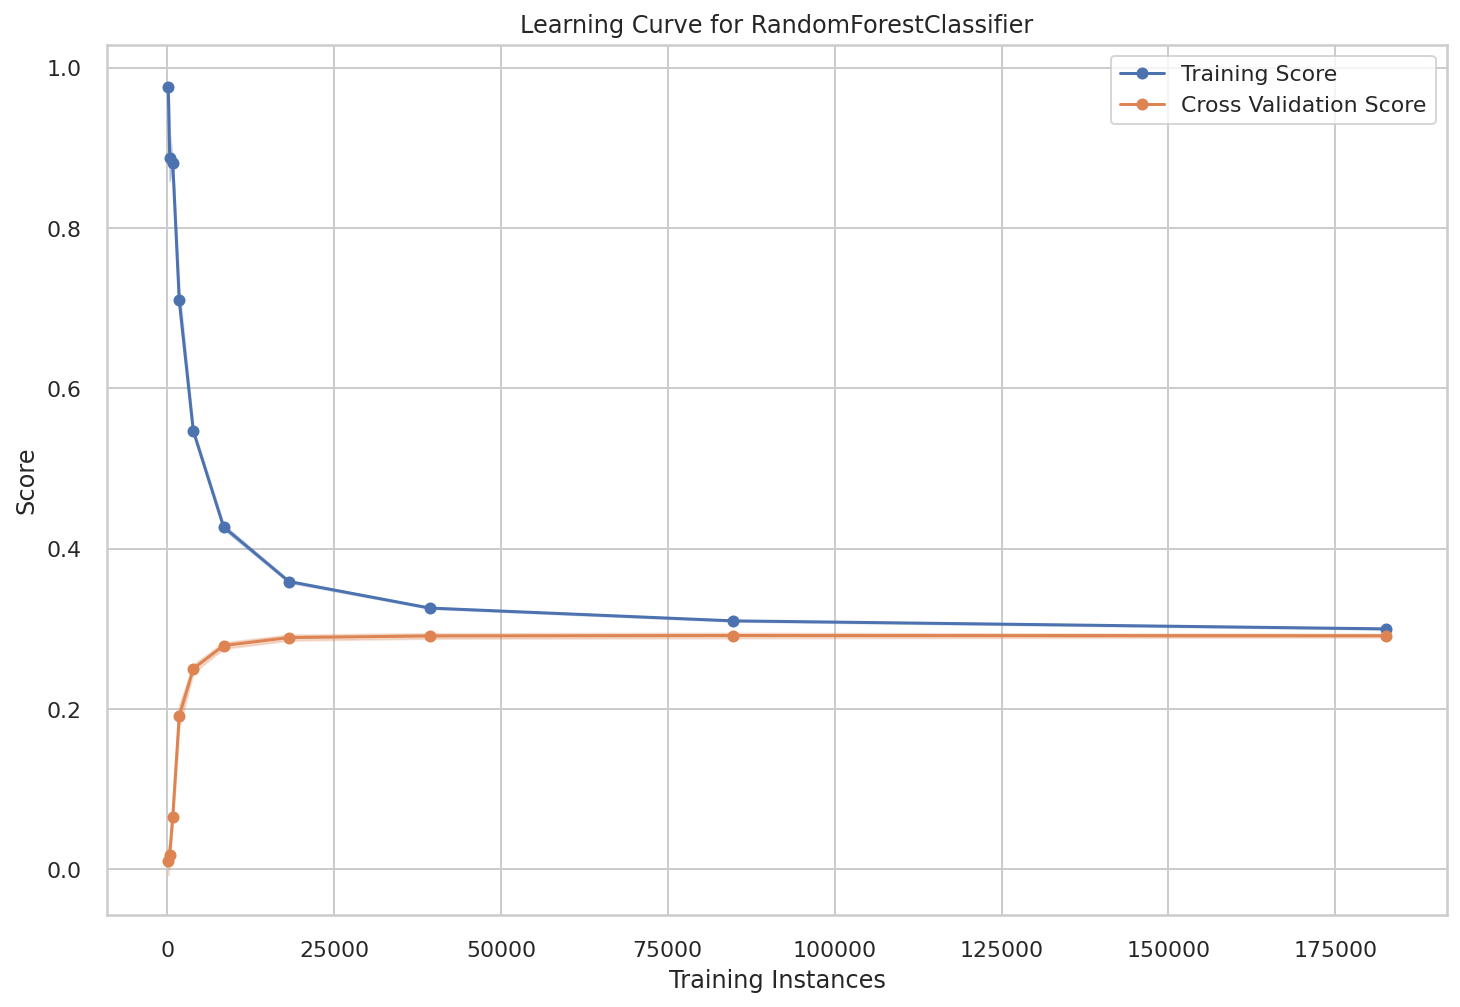

In [33]:
seed = 142

params = {'bootstrap': True,
          'class_weight': 'balanced',
          'criterion': 'gini',
          'max_depth': 8,
          'max_features': 'auto',
          'max_samples': 0.75,
          'n_estimators': 180,
          'n_jobs': -1,
          'random_state': seed,
          'verbose': 0}

rf_model = RandomForestClassifier(**params)

cv = StratifiedKFold(n_splits=10)
sizes = np.logspace(-3, 0, 10)

visualizer = LearningCurve(
    rf_model, cv=cv, scoring='f1', train_sizes=sizes, n_jobs=-1
)

visualizer.fit(X_res, y_res)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

### Grid search

In [37]:
seed = 142
params = {'bootstrap': [True],
          'class_weight': ['balanced'],
          'criterion': ['gini'],
          'max_depth': [16, 24, 36],
          'max_features': ['auto'],
          'max_samples': [0.75],
          'min_samples_leaf': [4, 8, 12],
          'min_samples_split': [8, 10, 14],
          'n_estimators': [30],
          'n_jobs': [-1],
          'random_state': [seed]}

estimator = RandomForestClassifier()

clf = GridSearchCV(estimator, 
                   param_grid=params, 
                   scoring='precision', 
                   n_jobs=-1,  
                   cv=3, 
                   verbose=2,  
                   return_train_score=False)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'class_weight': ['balanced'],
                         'criterion': ['gini'], 'max_depth': [16, 24, 36],
                         'max_features': ['auto'], 'max_samples': [0.75],
                         'min_samples_leaf': [4, 8, 12],
                         'min_samples_split': [8, 10, 14], 'n_estimators': [30],
                         'n_jobs': [-1], 'random_state': [142]},
             scoring='precision', verbose=2)

In [38]:
clf.best_score_

0.5992933550456393

In [39]:
clf.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 36,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': 0.75,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 30,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 142,
 'verbose': 0,
 'warm_start': False}